<a href="https://colab.research.google.com/github/Kraken2003/GANs/blob/main/anime_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sharl008
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:03<00:00, 112MB/s] 


In [21]:
import torch
import torch.nn as nn
import time
from tqdm.notebook import tqdm
from torchvision.utils import save_image
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
images = r'/content/animefacedataset'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
image_size = 64
batch_size = 128
norm = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm)])

ds = ImageFolder(root= images , transform = transf)

train_dl = DataLoader(ds, batch_size, shuffle=True)

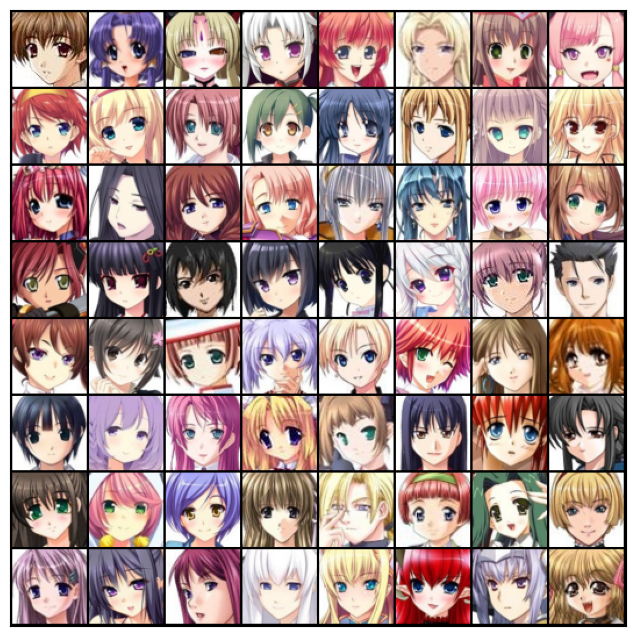

In [6]:
def denorm(img_tensors):
    return img_tensors * norm[1][0] + norm[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
show_batch(train_dl)

In [7]:
discriminator = nn.Sequential(

    #3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    #64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    #128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    #256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    #512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()

    #linear output

    )

In [8]:
discriminator.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [9]:
latent_size = 128
generator = nn.Sequential(

    #128 x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    #512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    #256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    #128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    #64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

    #3 x 64 x 64

)

In [10]:
generator.cuda()

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

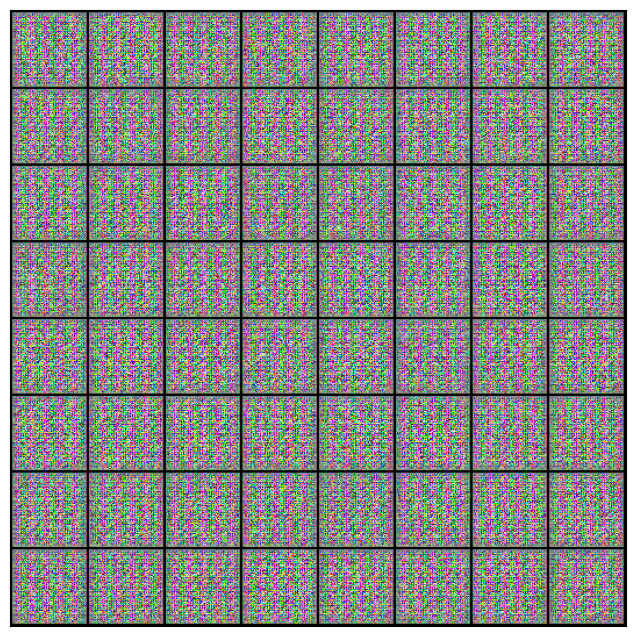

In [12]:
xb = torch.randn(batch_size, latent_size, 1, 1, device = device)
fake_images = generator(xb)
show_images(fake_images)

In [13]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    #teach it what a real image is
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    #we make a fake image
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    #test if it can distinguish a fake image from a real one
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [14]:
def train_generator(opt_g):
    opt_g.zero_grad()

    # make fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # get feedback from the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

Saving generated-images-0000.png


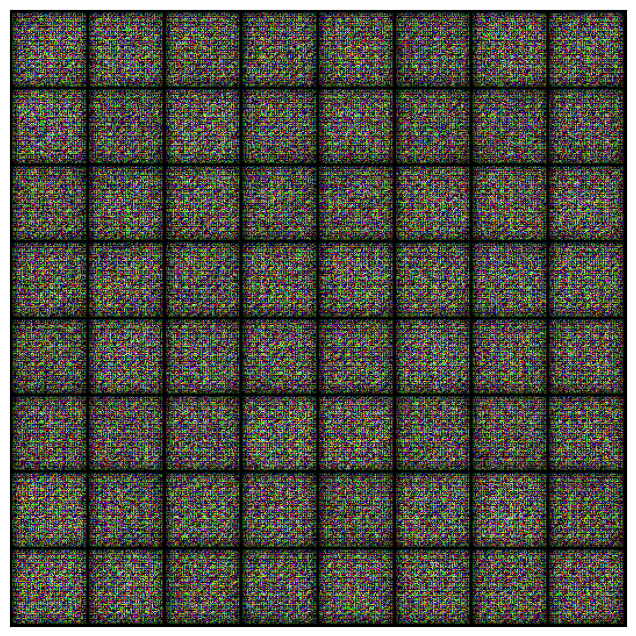

In [15]:
os.makedirs('progress', exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join('progress', fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [16]:
def fit(epochs, lr, start_idx=1):
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        start_time = time.time()
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.cuda()
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        end_time = time.time()
        epoch_time = end_time - start_time

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}, , Time elapsed: {:.2f} seconds".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score, epoch_time))

        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [17]:
lr = 0.0002
epochs = 50
model = fit(epochs,lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 2.4517, loss_d: 0.4302, real_score: 0.7869, fake_score: 0.1090, , Time elapsed: 140.84 seconds
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.2944, loss_d: 0.9054, real_score: 0.4928, fake_score: 0.0123, , Time elapsed: 140.09 seconds
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 4.4357, loss_d: 0.2869, real_score: 0.8363, fake_score: 0.0748, , Time elapsed: 140.60 seconds
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 12.0936, loss_d: 1.0365, real_score: 0.9603, fake_score: 0.5560, , Time elapsed: 140.46 seconds
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 4.5962, loss_d: 0.1916, real_score: 0.9110, fake_score: 0.0812, , Time elapsed: 140.00 seconds
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 5.9653, loss_d: 0.1801, real_score: 0.8735, fake_score: 0.0141, , Time elapsed: 139.64 seconds
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 5.5697, loss_d: 0.2686, real_score: 0.8083, fake_score: 0.0153, , Time elapsed: 139.75 seconds
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 5.9954, loss_d: 0.1642, real_score: 0.8770, fake_score: 0.0127, , Time elapsed: 139.66 seconds
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 4.4839, loss_d: 0.1782, real_score: 0.8668, fake_score: 0.0073, , Time elapsed: 139.90 seconds
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 4.6294, loss_d: 0.2095, real_score: 0.9041, fake_score: 0.0816, , Time elapsed: 139.92 seconds
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 10.3681, loss_d: 0.4194, real_score: 0.9955, fake_score: 0.3062, , Time elapsed: 139.57 seconds
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.5532, loss_d: 0.1169, real_score: 0.9214, fake_score: 0.0268, , Time elapsed: 139.60 seconds
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 4.9944, loss_d: 0.1856, real_score: 0.9230, fake_score: 0.0821, , Time elapsed: 138.99 seconds
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.9720, loss_d: 0.1816, real_score: 0.9974, fake_score: 0.1524, , Time elapsed: 139.05 seconds
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 5.3266, loss_d: 0.0796, real_score: 0.9335, fake_score: 0.0056, , Time elapsed: 139.10 seconds
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 5.0620, loss_d: 0.2100, real_score: 0.9262, fake_score: 0.1078, , Time elapsed: 139.24 seconds
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 3.8638, loss_d: 0.1271, real_score: 0.9483, fake_score: 0.0655, , Time elapsed: 139.33 seconds
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 2.3784, loss_d: 0.2883, real_score: 0.7849, fake_score: 0.0103, , Time elapsed: 139.61 seconds
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 10.1345, loss_d: 1.3430, real_score: 0.9924, fake_score: 0.5487, , Time elapsed: 139.42 seconds
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 3.9792, loss_d: 0.1323, real_score: 0.9118, fake_score: 0.0333, , Time elapsed: 139.44 seconds
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 4.1740, loss_d: 0.0817, real_score: 0.9480, fake_score: 0.0247, , Time elapsed: 138.62 seconds
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 5.1575, loss_d: 0.1418, real_score: 0.9732, fake_score: 0.0979, , Time elapsed: 140.33 seconds
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 3.9813, loss_d: 0.1472, real_score: 0.9653, fake_score: 0.0962, , Time elapsed: 140.51 seconds
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 0.5215, loss_d: 0.8474, real_score: 0.5212, fake_score: 0.0014, , Time elapsed: 140.96 seconds
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 5.9437, loss_d: 0.1410, real_score: 0.9861, fake_score: 0.1079, , Time elapsed: 141.17 seconds
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 2.9011, loss_d: 0.2532, real_score: 0.8483, fake_score: 0.0469, , Time elapsed: 141.43 seconds
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [19]:
torch.save(generator.state_dict(), '/content/drive/MyDrive/G.pth')
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/D.pth')

In [22]:
vid_fname = 'progress.avi'

files = [os.path.join('progress', f) for f in os.listdir('progress') if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()